**FINAL PROJECT PART 1: Text Processing and Exploratory Data Analysis**

- Iria Quintero (254373)
- Javier González (243078)
- Mireia Pou (251725)


# Part 0: Imports and Drive

In [1]:
#!pip install wordcloud

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import PorterStemmer

import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import pandas as pd
import numpy as np
import math
from numpy import linalg as la

from collections import Counter
import itertools
import networkx as nx
from datetime import datetime

from collections import defaultdict
from array import array
import collections

import zipfile
import json

import csv
import string
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load a pre-trained NER model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Part 1: Text Preprocessing

## 1.1 Data load

In [4]:
# Charging json data to variable data
# Specify name and path of .zip
zip_path = '/content/drive/Shareddrives/IRWA/Project/data/data.zip'

# Open .zip
with zipfile.ZipFile(zip_path) as z:
    # Read JSON from .zip line by line
    with z.open('data/farmers-protest-tweets.json') as f:
        data = []  # Initialize an empty list to store the JSON objects
        for line in f:
            try:
                # Attempt to parse each line as a JSON object
                json_obj = json.loads(line)
                data.append(json_obj)
            except json.JSONDecodeError as e:
                print(f"Skipping invalid line: {line} due to error: {e}")  # Print error and skip invalid lines


#Show JSON by printing a sample
print(f"Number of JSON objects loaded: {len(data)}")
if data:
    print("Sample JSON object:")
    print(data[0])

Number of JSON objects loaded: 117407
Sample JSON object:
{'url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198', 'date': '2021-02-24T09:23:35+00:00', 'content': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur https://t.co/es3kn0IQAF', 'renderedContent': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur twitter.com/ravisinghka/st…', 'id': 1364506249291784198, 'user': {'username': 'ArjunSinghPanam', 'displayname': 'Arjun Singh Panam', 'id': 45091142, 'description': 'Global Citizen, Actor, Director: Sky is the roof above my head, the world is the road I travel, love is my food & mother earth is my

Function to read the doc id to tweet id map file

In [5]:
def load_docid_map_from_zip(zip_file_path, csv_file_name):
    docid_map = {}
    with zipfile.ZipFile(zip_file_path) as z:
        with z.open(csv_file_name) as file:
            reader = csv.DictReader(file.read().decode('utf-8').splitlines())  # Decode and read the lines
            for row in reader:
                docid_map[row['id']] = row['docId']  # Map 'id' to 'docId'
    return docid_map

In [6]:
docid_map = load_docid_map_from_zip(zip_path, 'data/tweet_document_ids_map.csv')

## 1.2 Text preprocessing functions

In [7]:
def build_terms(line):
    """
    Preprocess the text by removing stop words, stemming,
    transforming to lowercase, removing hashtags, and returning tokens.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    stop_words.update(stopwords.words("hinglish"))  # Add Hindi stopwords
    stop_words.add("amp") # Add word amp to stop words since it is part of the & symbol

    ## Start preprocessing
    line = line.lower()  # Convert to lowercase
    line = re.sub(r'[^a-z0-9\s]', '', line)  # Remove every symbol that is not a letter or a number
    line = line.split()  # Tokenize the text to get a list of terms

   # Remove punctuation
    line = [word.translate(str.maketrans('', '', string.punctuation)) for word in line]
    line = [item for item in line if item not in stop_words]  # Remove stopwords
    line = [word for word in line if len(word) > 1]  # Remove single-letter words
    line = [stemmer.stem(word) for word in line]  # Stemming

    return line

Function to get DocID | TweetID | Tweet Content | Tokenized Tweet | Date | Hashtags | Likes | Retweets | Url from a json tweet

In [8]:
def extract_tweet_info_with_docid(tweet_json, docid_map):
    """
    Extracts specific information from a processed tweet's JSON object,
    including preprocessing the tweet content (tokenization, stop word removal, and stemming),
    and adds the corresponding docId.

    Args:
    tweet_json (dict): A dictionary representing a tweet in JSON format.
    docid_map (dict): A dictionary mapping tweet IDs to docIds.

    Returns:
    dict or None: A dictionary containing the extracted fields if a valid DocID is found,
    otherwise None.
    """
    # Extract the tweet ID
    tweet_id = tweet_json.get('id', '')

    # Find the corresponding docId from the map
    doc_id = docid_map.get(str(tweet_id))  # Use str(tweet_id) to ensure proper matching

    # If no matching docId is found, return None
    if not doc_id:
        return None

    # Extract the tweet content and preprocess it
    original_content = tweet_json.get('content', '')
    tokenized_content = build_terms(original_content)  # Apply text preprocessing

    # Extract the tweet's creation date
    tweet_date = tweet_json.get('date', '')

    # Extract hashtags from the tokenized content
    hashtags = re.findall(r'#\w+', original_content)

    # Extract likes and retweets
    tweet_likes = tweet_json.get('likeCount', 0)
    tweet_retweets = tweet_json.get('retweetCount', 0)

    # Extract tweet URL
    tweet_url = tweet_json.get('url', '')

    # Return the extracted information as a dictionary
    return {
        'DocID': doc_id,                # Include the docId
        'TweetID': tweet_id,
        'Original Tweet': original_content,
        'Tokenized Tweet': tokenized_content,
        'Date': tweet_date,
        'Hashtags': hashtags,
        'Likes': tweet_likes,
        'Retweets': tweet_retweets,
        'Url': tweet_url
    }


## 1.3 Tweet example

In [9]:
processed_data = []

for json_obj in data:
    # Create a copy of JSON original object
    processed_obj = json_obj.copy()  # Copia todos los campos del objeto JSON original

    # Check if content is in the object
    if 'content' in processed_obj:
        # Extraer información necesaria
        processed_obj = extract_tweet_info_with_docid(processed_obj, docid_map)

    # Add the processed object to the list if is not none
    if processed_obj is not None:
        processed_data.append(processed_obj)

# Shows a sample of the processed data
print(f"Number of JSON objects processed: {len(processed_data)}")
if processed_data:
    print("Sample processed data:")
    print(processed_data[0])

Number of JSON objects processed: 48429
Sample processed data:
{'DocID': 'doc_0', 'TweetID': 1364506249291784198, 'Original Tweet': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur https://t.co/es3kn0IQAF', 'Tokenized Tweet': ['world', 'progress', 'indian', 'polic', 'govt', 'india', 'back', 'horrif', 'past', 'tyranni', 'narendramodi', 'delhipolic', 'shame', 'modidontsellfarm', 'farmersprotest', 'freenodeepkaur', 'httpstcoes3kn0iqaf'], 'Date': '2021-02-24T09:23:35+00:00', 'Hashtags': ['#ModiDontSellFarmers', '#FarmersProtest', '#FreeNodeepKaur'], 'Likes': 0, 'Retweets': 0, 'Url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198'}


# Part 2: Exploratory Data Analysis

## 2.1 Basic statistics (topN words, word distribution, average sentence length)

In [10]:
def print_top_n_words(processed_data, n):

    all_words = []

    # Gather all tokenized words from each tweet
    for tweet in processed_data:
        all_words.extend(tweet['Tokenized Tweet'])

    # Calculate frequency distribution of all words
    word_freq = FreqDist(all_words)

    # Get the top n most common words
    top_n = word_freq.most_common(n)

    # Dictionary to return word: frequency
    frec = {}
    for word, freq in top_n:
        frec[word] = freq  # Assign word as key and freq as value
    return frec

frec = print_top_n_words(processed_data, 10) # Take only the first 10 items
print("Top 10 most common words:")
for word, freq in list(frec.items()):
    print(f"{word}: {freq}")


Top 10 most common words:
farmersprotest: 50106
farmer: 17306
india: 7651
support: 5993
protest: 4766
modi: 3113
indian: 3001
govern: 2739
bjp: 2665
law: 2553


Word Counting Distribution

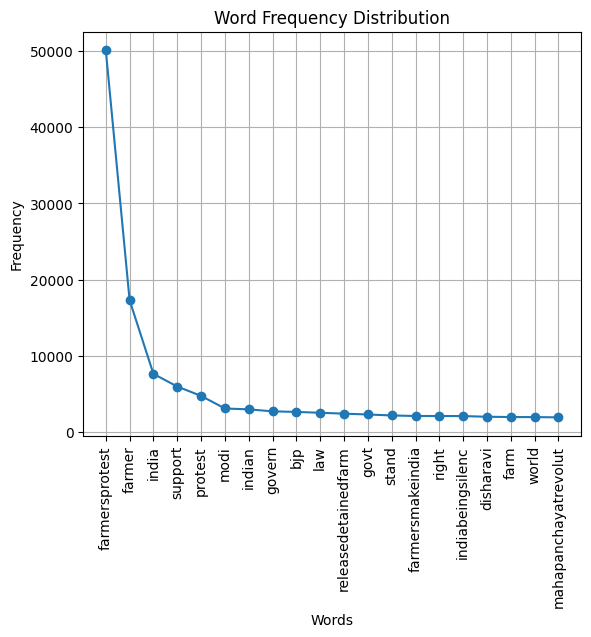

In [11]:
def word_count_distribution(processed_data, n):

    #get top words from previous function
    top_words = print_top_n_words(processed_data, n)

    #make a plot
    plt.plot(top_words.keys(), top_words.values(), marker='o')
    plt.title("Word Frequency Distribution")
    plt.tight_layout()
    plt.xlabel("Words")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

word_count_distribution(processed_data, 20)

Function for computing the average sentence length

In [12]:
def average_sentence_length(processed_data):
    sentence_lengths = [len(tweet['Tokenized Tweet']) for tweet in processed_data]
    avg_sentence_length = sum(sentence_lengths) / len(sentence_lengths)
    print(f"Average Sentence Length: {avg_sentence_length}")

average_sentence_length(processed_data)


Average Sentence Length: 12.827603295546057


## 2.2 Word Cloud of topN words

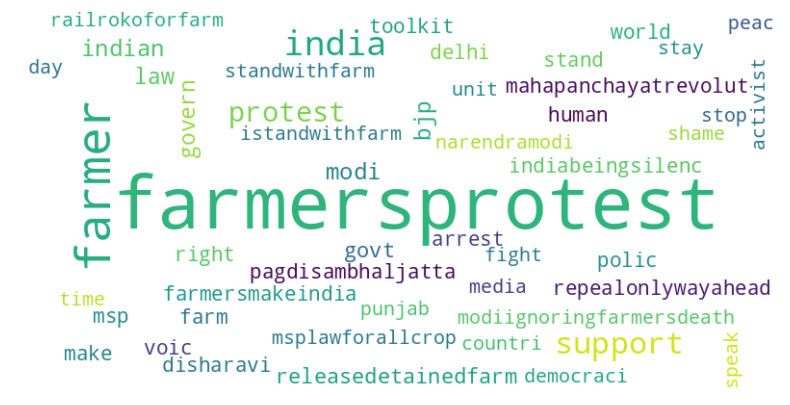

In [13]:
# Generate the WordCloud
frec = print_top_n_words(processed_data, 50)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frec)

# Display the WordCloud
plt.figure(figsize=(10, 5))  # Set figure size
plt.imshow(wordcloud, interpolation='bilinear')  # Display the wordcloud image
plt.axis("off")  # Turn off axis labels and ticks
plt.show()  # Show the plot

## 2.3 Retweeted tweets

In [14]:
def top_retweeted_tweets(processed_data, n):
    top_retweeted = sorted(processed_data, key=lambda x: x['Retweets'], reverse=True)[:n]
    print(f"Top {n} Tweets by Retweets:")
    i=1
    for tweet in top_retweeted:
        print(f"{i}. Tweet ID: {tweet['TweetID']} \nRetweets: {tweet['Retweets']} \nLikes: {tweet['Likes']} \nDate: {tweet['Date']}")
        print(f"Content: {tweet['Original Tweet']}\n")
        i= i+1

top_retweeted_tweets(processed_data, 10)

Top 10 Tweets by Retweets:
1. Tweet ID: 1364148079117615105 
Retweets: 6164 
Likes: 27888 
Date: 2021-02-23T09:40:21+00:00
Content: There's a #FarmersProtest happening in Germany.

But the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work. https://t.co/pZtigTgWT8

2. Tweet ID: 1360882069161803779 
Retweets: 4673 
Likes: 8974 
Date: 2021-02-14T09:22:23+00:00
Content: disha ravi, a 21-year-old climate activist, has been arrested by delhi police for sharing a toolkit @GretaThunberg  posted in support of the #farmersprotest. 

disha’s arrest is alarming and the world needs to pay attention. #freedisharavi

https://t.co/IYGsLpNjwZ

3. Tweet ID: 1360908603155050498 
Retweets: 3742 
Likes: 10403 
Date: 2021-02-14T11:07:50+00:00
Content: Disha Ravi broke down in court room and told judge that she had merely edited two lines in t

## 2.4 Entity recognition

In [15]:
def entity_recognition(processed_data, n=5):

    nlp = spacy.load("en_core_web_sm")

    # Analyze named entities in the original tweets
    for tweet in processed_data[:n]:  # Analyze only the first few tweets
        words = tweet['Original Tweet']
        doc = nlp(words)

        print(f"Tweet ID: {tweet['TweetID']}")
        for ent in doc.ents:
            print(f"Entity: {ent.text}, Label: {ent.label_}")

entity_recognition(processed_data, 5)

Tweet ID: 1364506249291784198
Entity: Indian, Label: NORP
Entity: Govt, Label: ORG
Entity: India, Label: GPE
Entity: FarmersProtest, Label: MONEY
Tweet ID: 1364506237451313155
Entity: FarmersProtest, Label: ORG
Entity: #ModiIgnoringFarmersDeaths, Label: MONEY
Entity: Farmers, Label: ORG
Entity: India, Label: GPE
Entity: 🚜, Label: GPE
Entity: https://t.co/kLspngG9xE, Label: GPE
Tweet ID: 1364506167226032128
Entity: @ReallySwara, Label: CARDINAL
Entity: #farmersprotest #, Label: MONEY
Tweet ID: 1364505991887347714
Entity: #farmersprotest #NoFarmersNoFood, Label: MONEY
Tweet ID: 1364505813834989568
Entity: #farmersprotest #NoFarmersNoFood https://t.co/NFMJeQRTJ2, Label: MONEY


## 2.5 Other interesting statistics

### 2.5.1 Most common hashtags and hashtags coocurrences

In [16]:
def most_common_hashtags(processed_data, n=10):
  all_hashtags = []
  for tweet in processed_data:
    if 'Hashtags' in tweet and tweet['Hashtags']:
      all_hashtags.extend(tweet['Hashtags'])

  hashtag_counts = Counter(all_hashtags)
  most_common = hashtag_counts.most_common(n)

  print("Most common hashtags:")
  for hashtag, count in most_common:
    print(f"{hashtag}: {count}")

most_common_hashtags(processed_data, 20)

Most common hashtags:
#FarmersProtest: 45856
#ReleaseDetainedFarmers: 2430
#farmersprotest: 2305
#FarmersMakeIndia: 2129
#IndiaBeingSilenced: 2128
#MahapanchayatRevolution: 1939
#DishaRavi: 1914
#RepealOnlyWayAhead: 1751
#Pagdi_Sambhal_Jatta: 1581
#FarmersProtests: 1564
#ModiIgnoringFarmersDeaths: 1316
#StandWithFarmers: 1312
#MSPLawForAllCrops: 1271
#RailRokoForFarmers: 1259
#IStandWithFarmers: 1184
#Farmers: 1129
#FreeNodeepKaur: 1111
#FreeDishaRavi: 1034
#DPstopIntimidatingFarmers: 957
#India: 895


Hashtags cooccurences

In [17]:
def hashtag_cooccurrence(processed_data, n):
    cooccurrence = Counter()

    # Get all combinations of hashtags from each tweet
    for tweet in processed_data:
        hashtags = tweet['Hashtags']
        if len(hashtags) > 1:
            for pair in itertools.combinations(hashtags, 2):
                cooccurrence[pair] += 1

    return cooccurrence.most_common(n)

# Example
n=20
cooccurrence = hashtag_cooccurrence(processed_data, n)

# Print the most common co-occurrences
print(f"Top {n} Hashtag Co-occurrences:")
for pair, count in cooccurrence:
   print(f"{pair}: {count}")

Top 20 Hashtag Co-occurrences:
('#FarmersProtest', '#ReleaseDetainedFarmers'): 1411
('#DishaRavi', '#FarmersProtest'): 1323
('#IndiaBeingSilenced', '#FarmersProtest'): 1249
('#FarmersMakeIndia', '#FarmersProtest'): 1130
('#Pagdi_Sambhal_Jatta', '#FarmersProtest'): 1060
('#FarmersProtest', '#MahapanchayatRevolution'): 1046
('#FarmersProtest', '#StandWithFarmers'): 1007
('#ReleaseDetainedFarmers', '#FarmersProtest'): 1000
('#FarmersProtest', '#FarmersMakeIndia'): 981
('#FarmersProtest', '#FarmersProtests'): 950
('#RepealOnlyWayAhead', '#FarmersProtest'): 881
('#MahapanchayatRevolution', '#FarmersProtest'): 832
('#FarmersProtest', '#IndiaBeingSilenced'): 828
('#MSPLawForAllCrops', '#FarmersProtest'): 828
('#FarmersProtest', '#RepealOnlyWayAhead'): 805
('#ModiIgnoringFarmersDeaths', '#FarmersProtest'): 765
('#RailRokoForFarmers', '#FarmersProtest'): 706
('#FarmersProtest', '#IStandWithFarmers'): 701
('#FarmersProtest', '#FarmersProtest'): 644
('#FreeNodeepKaur', '#FarmersProtest'): 630


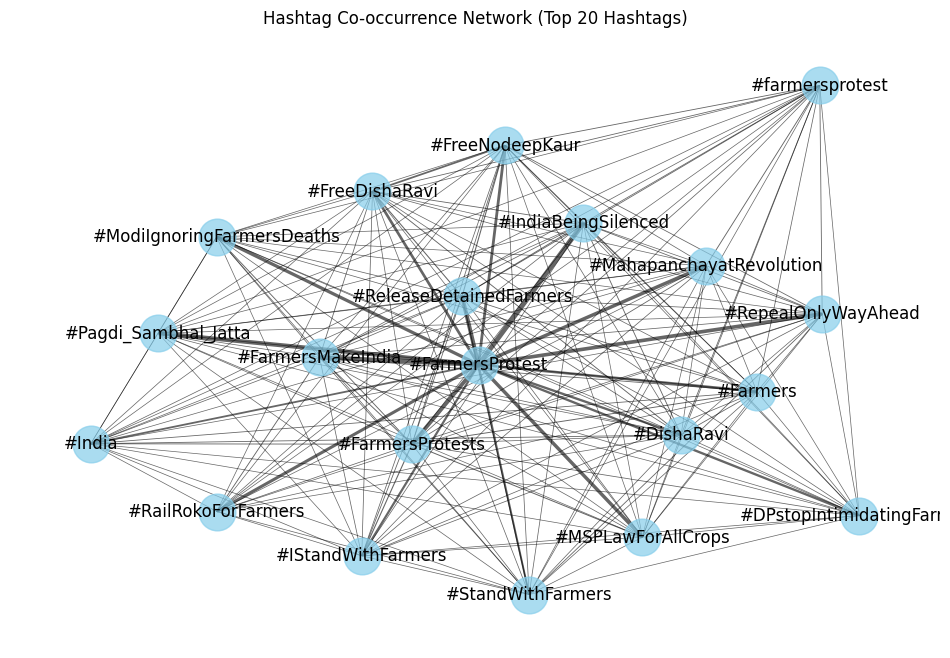

In [18]:
def hashtag_cooccurrence_network(processed_data, n=20):

    cooccurrence = Counter()

    # Get all combinations of hashtags from each tweet
    for tweet in processed_data:
        hashtags = tweet['Hashtags']
        if len(hashtags) > 1:
            for pair in itertools.combinations(hashtags, 2):
                cooccurrence[pair] += 1

    # Create a graph from the co-occurrences
    G = nx.Graph()

    # Add edges to the graph based on co-occurrences
    for (hashtag1, hashtag2), count in cooccurrence.items():
        if count > 0 and hashtag1 != hashtag2:  # Only consider pairs with positive co-occurrences
            G.add_edge(hashtag1, hashtag2, weight=count)

    # Get the top n hashtags based on the number of occurrences
    hashtag_counts = Counter()
    for hashtags in processed_data:
        for hashtag in hashtags['Hashtags']:
            hashtag_counts[hashtag] += 1

    # Get the top n hashtags
    top_hashtags = [hashtag for hashtag, _ in hashtag_counts.most_common(n)]

    # Create a subgraph with only the top n hashtags
    top_edges = [(u, v) for u, v in G.edges() if u in top_hashtags and v in top_hashtags]
    top_G = G.edge_subgraph(top_edges).copy()

    # Draw the graph
    pos = nx.spring_layout(top_G)  # positions for all nodes
    weights = [top_G[u][v]['weight'] for u, v in top_G.edges()]

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(top_G, pos, node_size=700, node_color='skyblue', alpha=0.7)

    # Adjust edge color and width for better visibility
    edge_color = 'black'
    edge_alpha = 0.6
    max_weight = max(weights) if weights else 1  # Avoid division by zero
    widths = [0.5 + 3 * (weight / max_weight) for weight in weights]  # Scale the weights for visibility

    nx.draw_networkx_edges(top_G, pos, width=widths, alpha=edge_alpha, edge_color=edge_color)
    nx.draw_networkx_labels(top_G, pos, font_size=12, font_family='sans-serif')

    plt.title(f"Hashtag Co-occurrence Network (Top {n} Hashtags)")
    plt.axis('off')  # Turn off the axis
    plt.show()

# Example
hashtag_cooccurrence_network(processed_data, n=20)

### 2.5.2 Most retweeted users

Preprocessing to add fields

In [26]:
def extract_extended_tweet_info_with_docid(tweet_json, docid_map):
    # Extract the same fields as before
    tweet_id = tweet_json.get('id', '')
    doc_id = docid_map.get(str(tweet_id))  # Use str(tweet_id) to ensure proper matching

    if not doc_id:
        return None

    original_content = tweet_json.get('content', '')
    tokenized_content = build_terms(original_content)  # Apply text preprocessing
    tweet_date = tweet_json.get('date', '')

    hashtags = re.findall(r'#\w+', original_content)
    tweet_likes = tweet_json.get('likeCount', 0)
    tweet_retweets = tweet_json.get('retweetCount', 0)
    tweet_url = tweet_json.get('url', '')

    # Extract user information (username and follower count)
    user_info = tweet_json.get('user', {})
    username = user_info.get('username', 'unknown')
    followers_count = user_info.get('followersCount', 0)

    # Return the extracted information as a dictionary
    return {
        'DocID': doc_id,
        'TweetID': tweet_id,
        'Original Tweet': original_content,
        'Tokenized Tweet': tokenized_content,
        'Date': tweet_date,
        'Username': username,           # Twitter username
        'FollowersCount': followers_count,  # Number of followers
        'Hashtags': hashtags,
        'Likes': tweet_likes,
        'Retweets': tweet_retweets,
        'Url': tweet_url
    }

In [27]:
extended_processed_data = []

for json_obj in data:
    # Crete a JSON object copy
    processed_obj = json_obj.copy()

    # Verify that "content" is present
    if 'content' in processed_obj:
        # Extract necessary informaiton
        processed_obj = extract_extended_tweet_info_with_docid(processed_obj, docid_map)

    # Add object if is not None
    if processed_obj is not None:
        extended_processed_data.append(processed_obj)

# show processed data
print(f"Number of JSON objects processed: {len(extended_processed_data)}")
if extended_processed_data:
    print("Sample processed data:")
    print(extended_processed_data[0])

Number of JSON objects processed: 48429
Sample processed data:
{'DocID': 'doc_0', 'TweetID': 1364506249291784198, 'Original Tweet': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur https://t.co/es3kn0IQAF', 'Tokenized Tweet': ['world', 'progress', 'indian', 'polic', 'govt', 'india', 'back', 'horrif', 'past', 'tyranni', 'narendramodi', 'delhipolic', 'shame', 'modidontsellfarm', 'farmersprotest', 'freenodeepkaur', 'httpstcoes3kn0iqaf'], 'Date': '2021-02-24T09:23:35+00:00', 'Username': 'ArjunSinghPanam', 'FollowersCount': 603, 'Hashtags': ['#ModiDontSellFarmers', '#FarmersProtest', '#FreeNodeepKaur'], 'Likes': 0, 'Retweets': 0, 'Url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198'}


Most retweeted users

Top 10 Users with Most Retweeted Tweets:
User 1364148079117615105: 6164 retweets
Username: dhruv_rathee
Followers Count: 1025117
------------------------------
User 1360882069161803779: 4673 retweets
Username: rupikaur_
Followers Count: 268846
------------------------------
User 1360908603155050498: 3742 retweets
Username: amaanbali
Followers Count: 28255
------------------------------
User 1360162861419425795: 3332 retweets
Username: jedijasmin_
Followers Count: 847
------------------------------
User 1361790921902338048: 3230 retweets
Username: rupikaur_
Followers Count: 268846
------------------------------
User 1360260269646237699: 3182 retweets
Username: RaviSinghKA
Followers Count: 227429
------------------------------
User 1361037112783499264: 2495 retweets
Username: sushant_says
Followers Count: 200177
------------------------------
User 1363421524879843336: 2258 retweets
Username: amaanbali
Followers Count: 28254
------------------------------
User 1360893759173500930: 2208 re

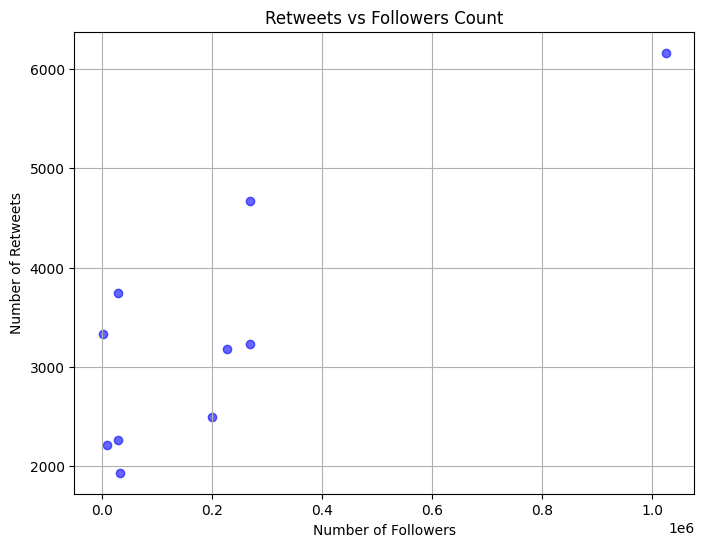

In [28]:
def most_retweeted_users(extended_processed_data, top_n=10):

    # Dictionary to store total retweets for each user
    user_retweets = Counter()

    # Dictionary to store additional info for each user (e.g., username, followers)
    user_info = {}

    for tweet in extended_processed_data:
        user_id = tweet['TweetID']  # Unique tweet ID
        retweets = tweet['Retweets']  # Number of retweets
        username = tweet['Username']  # Username of the tweet author
        followers_count = tweet['FollowersCount']  # Number of followers

        # Add retweets count to the corresponding user
        user_retweets[user_id] += retweets

        # Store additional information about the user (only if not already stored)
        if user_id not in user_info:
            user_info[user_id] = {
                'username': username,
                'followers_count': followers_count
            }

    # Get the top N users with the most retweeted tweets
    most_retweeted = user_retweets.most_common(top_n)

    retweets_list = []
    followers_list = []

    # Print the most retweeted users with additional info
    print(f"Top {top_n} Users with Most Retweeted Tweets:")
    for user, retweets in most_retweeted:
        username = user_info[user]['username']
        followers_count = user_info[user]['followers_count']

        retweets_list.append(retweets)
        followers_list.append(followers_count)

        print(f"User {user}: {retweets} retweets")
        print(f"Username: {username}")
        print(f"Followers Count: {followers_count}")
        print("-" * 30)  # Just to separate the users visually

    # Plotting retweets vs followers
    plt.figure(figsize=(8, 6))
    plt.scatter(followers_list, retweets_list, color='blue', alpha=0.6)
    plt.title('Retweets vs Followers Count')
    plt.xlabel('Number of Followers')
    plt.ylabel('Number of Retweets')
    plt.grid(True)
    plt.show()

# Example usage
most_retweeted_users(extended_processed_data, top_n=10)


### 2.5.3 Tweets time evolution

<ipython-input-22-c75d77b71214>:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  date_counts = date_series.dt.to_period(time_interval).value_counts().sort_index()


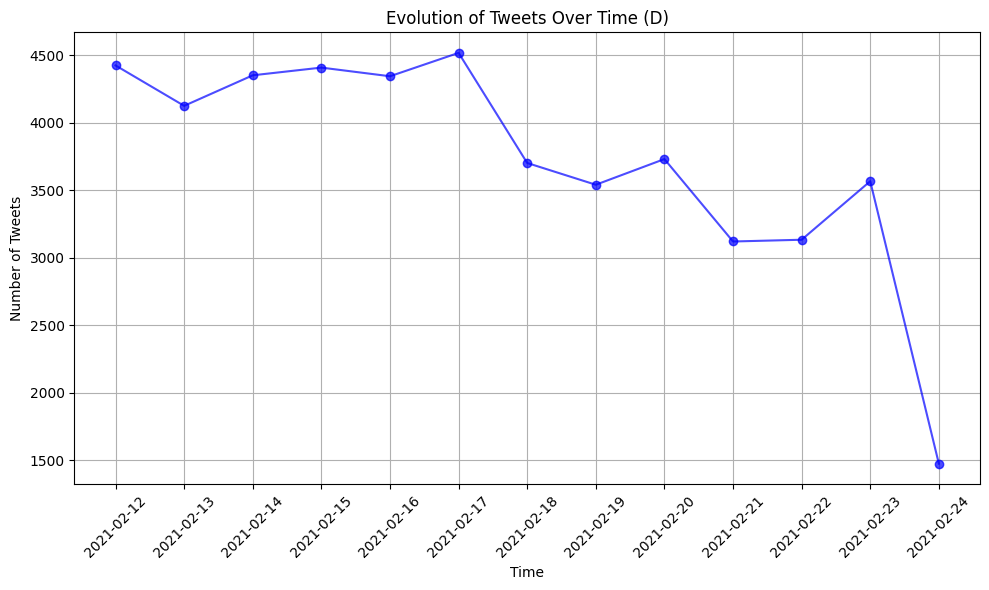

In [22]:
def plot_tweets_over_time(extended_processed_data, time_interval='D'):

    # Extract dates from the tweets and convert them to datetime objects
    dates = [datetime.strptime(tweet['Date'], '%Y-%m-%dT%H:%M:%S%z') for tweet in extended_processed_data]

    # Convert dates to a pandas Series
    date_series = pd.Series(dates)

    # Group by the specified time interval ('D' for daily, 'W' for weekly, 'M' for monthly)
    date_counts = date_series.dt.to_period(time_interval).value_counts().sort_index()

    # Plotting the evolution of tweets over time
    plt.figure(figsize=(10, 6))
    plt.plot(date_counts.index.astype(str), date_counts.values, marker='o', color='blue', linestyle='-', alpha=0.7)
    plt.title(f'Evolution of Tweets Over Time ({time_interval})')
    plt.xlabel('Time')
    plt.ylabel('Number of Tweets')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_tweets_over_time(extended_processed_data, time_interval='D')